# Investigate ice-liquid separation& three comp plots
Target 42 clusters first

In [1]:
%matplotlib inline
import os
import gc
import re
import copy
import time
import glob
import scipy
import numpy as np
import pandas as pd
import netCDF4
import pickle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import matplotlib.ticker as mticker
from adjustText import adjust_text

## Exec aggregation

In [4]:
def read_netcdf(filename, varname):
    nc = netCDF4.Dataset(filename, 'r')
    var = nc.variables[varname][:].data
    nc.close()
    return var

In [5]:
def read_netcdf_stats(filename, varname):
    '''varname = {mode, clear-sky, liquid, ice, undef }
    '''
    nc = netCDF4.Dataset(filename, 'r')
    var = nc.groups['statistics']['category'][varname][:].data
    nc.close()
    return var

In [6]:
def calc_param(filelist,nclusters=None, varnames=['clear-sky', 'liquid', 'ice','undef' ], 
               phases=[0,1,2,6]):
    # define array
    param_array = np.zeros((nclusters,len(phases)), dtype=np.float64)
    count_array = np.zeros((nclusters,len(phases)), dtype=np.float64)
    label_name=f'labels_nc-{nclusters}'
    s1 = time.time()
    for idx, ifile in enumerate(filelist):
        file_flag=False
        try:
            _label = read_netcdf(filename=ifile, varname=label_name)
            file_flag = True
        except Exception as e:
            pass
        
        
        if file_flag:
            for vdx, _varname in enumerate(varnames):
                data = read_netcdf_stats(filename=ifile, varname=_varname)
                for ic in range(nclusters):
                    ic_idx = np.where(_label == ic)
                    param_array[ic, vdx] += np.nansum(data[ic_idx])
                    count_array[ic, vdx] += len(data[ic_idx])*128*128
    
        if idx % 400 == 0:
            s2 = time.time()  -s1
            print(f" {idx/len(filelist) * 100} % DONE : {s2/60.0} mins  ")
    # average
    #avg_array = param_array /np.sum(param_array)
    avg_array = np.divide(param_array,count_array, out=np.zeros_like(param_array), 
                          where=count_array!=0)
    return avg_array

### Main run

In [41]:
sday = 1
eday = 31
sday = 182
eday = 212
nclusters=42
filelist = []
for _iday in range(sday,eday+1,1):
    iday = str(_iday).zfill(3)
    filelist.extend(glob.glob(os.path.join(*[modis_datadir, iday, expname, '*.nc'])))

In [42]:
len(filelist)

4267

In [43]:
avg_array = calc_param(filelist,nclusters=42,)

 0.0 % DONE : 0.003272684415181478 mins  
 9.37426763534099 % DONE : 1.3652856906255086 mins  
 18.74853527068198 % DONE : 2.4745825926462808 mins  
 28.122802906022965 % DONE : 3.6518839955329896 mins  
 37.49707054136396 % DONE : 4.687467098236084 mins  
 46.871338176704946 % DONE : 5.9332185308138525 mins  
 56.24560581204593 % DONE : 7.576672228177388 mins  
 65.61987344738692 % DONE : 9.094425674279531 mins  
 74.99414108272792 % DONE : 10.676805539925892 mins  
 84.3684087180689 % DONE : 12.183774038155873 mins  
 93.74267635340989 % DONE : 13.731179865201314 mins  


### Total run

In [45]:
nclusters=42

filelist = []
sday = 1
eday = 31
for _iday in range(sday,eday+1,1):
    iday = str(_iday).zfill(3)
    filelist.extend(glob.glob(os.path.join(*[modis_datadir, iday, expname, '*.nc'])))
    
sday = 182
eday = 212
for _iday in range(sday,eday+1,1):
    iday = str(_iday).zfill(3)
    filelist.extend(glob.glob(os.path.join(*[modis_datadir, iday, expname, '*.nc'])))

In [46]:
len(filelist)

8308

In [47]:
avg_array = calc_param(filelist,nclusters=42,)

 0.0 % DONE : 0.006348911921183268 mins  
 4.814636494944632 % DONE : 1.8985350728034973 mins  
 9.629272989889264 % DONE : 3.555445150534312 mins  
 14.443909484833895 % DONE : 5.300237925847371 mins  
 19.25854597977853 % DONE : 7.054505825042725 mins  
 24.073182474723158 % DONE : 8.548339068889618 mins  
 28.88781896966779 % DONE : 9.619247237841288 mins  
 33.70245546461243 % DONE : 10.716178087393443 mins  
 38.51709195955706 % DONE : 11.998455500602722 mins  
 43.331728454501686 % DONE : 13.196553762753805 mins  
 48.146364949446316 % DONE : 14.540588597456614 mins  
 52.96100144439095 % DONE : 16.209653508663177 mins  
 57.77563793933558 % DONE : 17.78446209828059 mins  
 62.59027443428021 % DONE : 19.32638599872589 mins  
 67.40491092922485 % DONE : 21.12424526611964 mins  
 72.21954742416948 % DONE : 22.650253939628602 mins  
 77.03418391911411 % DONE : 23.932125079631806 mins  
 81.84882041405874 % DONE : 25.17668509085973 mins  
 86.66345690900337 % DONE : 26.43974031209945

#### Instant sanity-check

In [14]:
np.sum(avg_array)

37.0

In [28]:
df = pd.DataFrame(avg_array, columns=['clear-sky', 'liquid', 'ice','undef' ] )

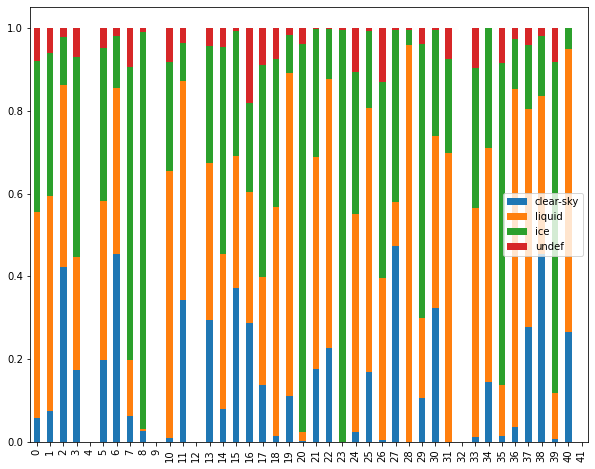

In [32]:
plt.figure(figsize=(10,8))
ax = plt.subplot(111)
df.plot( stacked=True,kind='bar',ax=ax)
plt.show()

#### save

In [27]:
outputdir='/home/tkurihana/modis-climate/anl/output/outputs/2003-015-105-195-288_053-132-185-315'

In [48]:
# winter: jan 2003
#sday=1
#eday=212
#ofilename=f"ice_liquid-2003-{sday}-{eday}-{nclusters}.npy"
#np.save(os.path.join(outputdir,ofilename), avg_array)

### Automate run

In [34]:
for nclusters in [10,256]:
    #for sday, eday in zip([1,182], [15,195]):
    for sday, eday in zip([1], [15]):    
        filelist = []
        for _iday in range(sday,eday+1,1):
            iday = str(_iday).zfill(3)
            filelist.extend(glob.glob(os.path.join(*[modis_datadir, iday, expname, '*.nc'])))
    
        print(len(filelist))
        print(f"START: NC={nclusters} {sday}--{eday}")
        # result
        avg_array = calc_param(filelist,nclusters=nclusters)
            
        # save
        ofilename=f"ice_liquid-2003-{sday}-{eday}-{nclusters}.npy"
        np.save(os.path.join(outputdir,ofilename), avg_array)

1987
START: NC=10 1--15
 0.0 % DONE : 0.003979738553365072 mins  
 20.130850528434827 % DONE : 1.597848323980967 mins  
 40.261701056869654 % DONE : 2.9775273124376933 mins  
 60.392551585304474 % DONE : 4.372787896792094 mins  
 80.52340211373931 % DONE : 5.791304127375285 mins  
1987
START: NC=256 1--15
 0.0 % DONE : 0.004195459683736165 mins  
 20.130850528434827 % DONE : 1.541476845741272 mins  
 40.261701056869654 % DONE : 2.9365266521771747 mins  
 60.392551585304474 % DONE : 4.2201808055241905 mins  
 80.52340211373931 % DONE : 5.270798472563426 mins  


-----------------
## Analysis

#### Load rename base

In [54]:
rdf = pd.read_csv("./csvs/sort_cot-ctp_means.csv")

#### Sort based on rename-df

In [10]:
def my_relabel_fn(df, avg_array):
    ravg_array = np.zeros(avg_array.shape)
    for ic, ocluster in enumerate(df['cluster'].tolist()):
        oc_index = ocluster - 1  # change 1 - N in df to 0 - N-1 index
        ravg_array[ic] = avg_array[oc_index]
    return ravg_array

In [57]:
ravg_array = my_relabel_fn(rdf, avg_array)

Show all percentages at once

In [58]:
df = pd.DataFrame(ravg_array, columns=['clear-sky', 'liquid', 'ice','undef' ] )

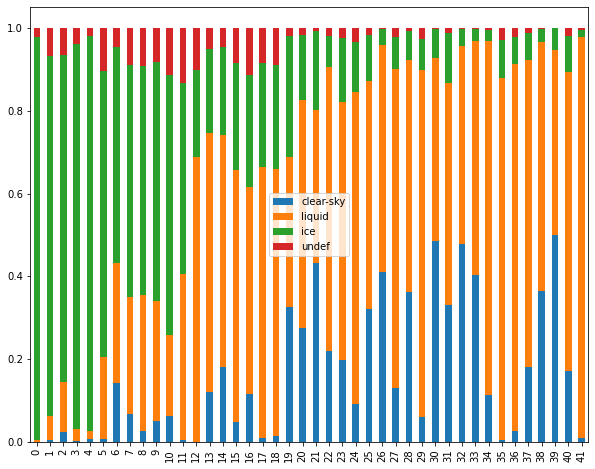

In [59]:
plt.figure(figsize=(10,8))
ax = plt.subplot(111)
df.plot( stacked=True,kind='bar',ax=ax)
plt.show()

Show ice percentage

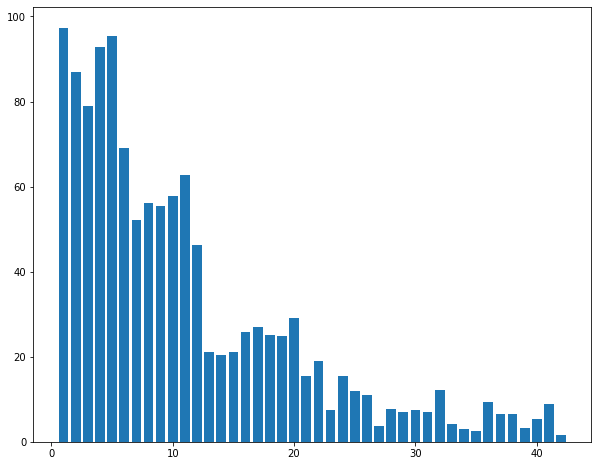

In [60]:
plt.figure(figsize=(10,8))
ax = plt.subplot(111)
ax.bar(np.arange(1,nclusters+1,1), df['ice'].to_numpy()*100.0)
plt.show()

----------------------
##  Three component cot-ctp-ice ratio plot

In [7]:
def pkl_reader(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

In [39]:
year='2003'
#sday=1
#eday=15
#eday=31
sday=182
eday=195
#eday=212


# label days
#lsday=182
lsday=1
#leday=195
#leday=15
leday=212

expname='10021600'
layer_name = 'leaky_re_lu_21'

In [9]:
outputdir = '/home/tkurihana/modis-climate/anl/output'

In [40]:
results = dict()
labels  = dict()
moments = dict()
outputdir = '/home/tkurihana/modis-climate/anl/output'
ctimestamp = '2003-015-105-195-288_053-132-185-315'
nclusters =  [42] #[10,42,64, 256]
for ncluster in nclusters:
    try:
        avg_array = np.load(f"{outputdir}/outputs/{ctimestamp}/calc_param-2003-{sday}-{eday}-{ncluster}.npy",
                        allow_pickle=True)
    except Exception as e:
        avg_array = None
        print(f'error parameter: {e}')
        pass
    results[ncluster] = avg_array # (#nclusters, 2): (1) cot, (2) ctp
    #
    try:
        #data = pkl_reader(f'{outputdir}/outputs/{ctimestamp}/rfos-2003-{lsday}-{leday}-{ncluster}.pkl')
        if ncluster == 42:
            peday = 31 if eday == 15 else 212
            ofilename=f"ice_liquid-2003-{sday}-{peday}-{ncluster}.npy"
        else:
            ofilename=f"ice_liquid-2003-{sday}-{eday}-{ncluster}.npy"
        cluster_freq = np.load(f'{outputdir}/outputs/{ctimestamp}/{ofilename}')
    except Exception as e:
        print(f'error RFO: {e}')
        pass
    labels[ncluster] = cluster_freq
    # not necessary
    try:
        ## three dim figures
        mom_array = np.load(f"{outputdir}/outputs/{ctimestamp}/calc_moment-2003-{lsday}-{leday}-{ncluster}.npy",
                        allow_pickle=True)
    except Exception as e:
        print(f'error RFO: {e}')
        pass
    moments[ncluster] = mom_array

In [22]:
def plot_scatter(results, moments, labels, 
                 figsize=(10,8), cmap='nipy_spectral',ss=800,dy=12,
                 ew=1,caps=3,alpha=0.6, ncluster = 12, ftex = 15, month='Jan',
                 tex_x_pos=[],fyl=16, fts=16,
                 flag_save=False, PDF=False, savefigdir='',
                 hxmin=0.002,hxmax=256,
                 flag_adjust=True, limit_annotate=False,thres_annotate=0.75,adjust_fp=0,
                 arrow=False, relabels={},
                ):
    fig = plt.figure(figsize=figsize)

    ax = plt.subplot(1,1,1)
    opts =  results[ncluster][:,0] 
    eopts = moments[ncluster][:,0]
    
    #if ew > 0:
    #    ax.scatter(opts, results[ncluster][:,1],
    #         ls='none', color='grey', elinewidth=ew,capsize=caps,zorder=-32)
    sc = ax.scatter( opts, results[ncluster][:,1],s=ss,c=labels[ncluster][:,2]*100, cmap=cmap, alpha=alpha,vmin=0, vmax=100 )
    
    # limit annotate data
    if limit_annotate:
        # + 1 for index to align with the range from (1,ncluster)
        selected_clusters = np.where( 
            labels[ncluster][:,2]*100 >= np.quantile(labels[ncluster][:,2]*100, thres_annotate))[0] + 1
    else:
        selected_clusters = np.arange(1,ncluster+1,1)
    
    # text annotation
    texts = []
    xas, yas = [], []
    for ic, ix, iy in zip(np.arange(1,ncluster+1,1),tex_x_pos, results[ncluster][:,1]):
        if ic in selected_clusters:
            #ax.text(ix,iy+dy, f'{ic}', fontsize=ftex)
            
            # AD-hoc for nclusters == 42: since relabeled
            #if ncluster == 42:
            ric = relabels[ic]
            texts.append(plt.text(ix,(iy+dy), f'{ric}', fontsize=ftex))
            #else:
            #    texts.append(plt.text(ix,(iy+dy), f'{ic}', fontsize=ftex))
                #texts.append(ax.text(ix,(iy+dy), f'{ic}', fontsize=ftex))
            
            
            #print(ix, iy+dy)
            #if arrow:
            #    ax.text(ix,(iy+dy), f'{ic}', fontsize=ftex)
            #else arrow:
            #    texts.append(plt.text(ix,(iy+dy), f'{ic}', fontsize=ftex))
            #xas.append(ix)
            #yas.append(iy+dy)
    #if arrow:
    #    pass
        #adjust_text(texts,autoalign=False, only_move={'points':'y', 'text':'y', 'objects':'y'},
         #          ha='center', va='bottom')
        #adjust_text(texts,arrowprops=dict(arrowstyle='->', color='red'),)
                   #ha='center', va='bottom')
    #else:
    if flag_adjust:
        adjust_text(texts,ha='center', va='bottom') # 
            
    # y axis
    ax.set_ylim(100,1001)
    ax.set_yticks([180, 310,440,560, 680, 800, 1000])
    ax.invert_yaxis()
    # x axis
    ax.set_xscale('log')
    ax.set_xlim(hxmin,hxmax)
    ax.xaxis.set_major_formatter(mticker.NullFormatter())
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    #ax.set_xticks( [ i for i in [0.2, 1.3, 3.6, 9.4, 23, 60, hxmax]])
    ax.set_xticks( [ i for i in [0.2, 1.3, 3.6, 9.4, 23, 60]])

    # v.1
    ## hline
    #nvmax = np.max(opts)
    #idmax = np.argmax(eopts)
    #ax.hlines( 440, 0, hxmax, color='grey', linestyle=':')
    #ax.hlines( 680, 0, hxmax, color='grey', linestyle=':')
    ## vline
    #ax.vlines(23, 100, 1000, color='grey', linestyle=':', )
    #ax.vlines(3.6, 100, 1000, color='grey', linestyle=':', )
    
    # v.2
    ax.hlines( 440, 0, hxmax, color='black', linestyle=':')
    ax.hlines( 680, 0, hxmax, color='black', linestyle=':')
    # vline
    ax.vlines(23, 100, 1000, color='black', linestyle=':', )
    ax.vlines(3.6, 100, 1000, color='black', linestyle=':', )
    
    cbar = fig.colorbar(sc)
    cbar.ax.set_ylabel('Ice ratio [%]', fontsize=fyl)
    # label
    ax.set_xlabel('Cloud optical thickness', fontsize=fts)
    ax.set_ylabel('Cloud top pressure [hPa]', fontsize=fts)

    
    #fig.colorbar(sc)
    #plt.show()
    if flag_save:
        if PDF:
            pdf = PdfPages(os.path.join(savefigdir, f'COT-CPT-Ice_{month}-{ncluster}.pdf') )
            plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
            pdf.close()
            pdf = None
        else:
            plt.savefig(os.path.join(savefigdir, f'COT-CPT-Ice_{month}-{ncluster}.png'))
    plt.show()
    plt.close()

### Visualize

In [28]:
# cluster range 1 -- N+1
relabels = {}
for nclusters in [10,42,64,256]:
    df = pd.read_csv(f"./csvs/sort_cot-ctp_means-{nclusters}.csv", index_col=0)
    tmp = {}
    for ic, ric in zip(df['cluster'], df['rcluster']):
        tmp[ic] = ric
    relabels[nclusters] = tmp

In [33]:
pd.read_csv(f"./csvs/sort_cot-ctp_means-10.csv", index_col=0)

,cot,ctp,rfo,cluster,rcluster
0,16.153702,385.844720,6.327429,6,1
1,5.194431,612.307231,13.165498,7,2
2,6.953486,691.820194,6.583524,1,3
3,7.490960,739.033379,32.814252,2,4
4,14.987167,705.042117,16.120279,9,5
5,16.882211,726.361516,6.825406,3,6
6,5.259588,803.772022,5.990449,10,7
7,8.844971,802.084297,3.845041,4,8
8,11.944222,844.290448,2.178228,8,9
9,5.213706,865.251155,6.149894,5,10


-------------------------
## V2: Align four seasons

In [3]:
year='2003'
expname='10021600'
# label days
lsday=1
_leday=195
layer_name = 'leaky_re_lu_21'

In [4]:
outputdir = '/home/tkurihana/modis-climate/anl/output'

In [5]:
all_results = {}

#### Collect data

In [6]:
for sday, _eday, month in zip([1, 182],[15,195], ['jan', 'july'] ):
    results = dict()
    labels  = dict()
    moments = dict()
    outputdir = '/home/tkurihana/modis-climate/anl/output'
    ctimestamp = '2003-015-105-195-288_053-132-185-315'
    nclusters =  [10,42,64, 256]
    for ncluster in nclusters:
        
        if nclusters == 42: 
            if sday == 1:
                eday = 31
            elif sday == 182:
                eday = 212
        
        else:
            leday = _leday
            eday = _eday
        
        
        try:
            avg_array = np.load(f"{outputdir}/outputs/{ctimestamp}/calc_param-2003-{sday}-{eday}-{ncluster}.npy",
                        allow_pickle=True)
        except Exception as e:
            avg_array = None
            print(f'error parameter: {e}')
            pass
        results[ncluster] = avg_array # (#nclusters, 2): (1) cot, (2) ctp
        #
        try:
        #data = pkl_reader(f'{outputdir}/outputs/{ctimestamp}/rfos-2003-{lsday}-{leday}-{ncluster}.pkl')
            if ncluster == 42:
                peday = 31 if eday == 15 else 212
                ofilename=f"ice_liquid-2003-{sday}-{peday}-{ncluster}.npy"
            else:
                ofilename=f"ice_liquid-2003-{sday}-{eday}-{ncluster}.npy"
            cluster_freq = np.load(f'{outputdir}/outputs/{ctimestamp}/{ofilename}')
        except Exception as e:
            print(f'error RFO: {e}')
            pass
        labels[ncluster] = cluster_freq
        # not necessary
        try:
            ## three dim figures
            mom_array = np.load(f"{outputdir}/outputs/{ctimestamp}/calc_moment-2003-{lsday}-{leday}-{ncluster}.npy",
                        allow_pickle=True)
        except Exception as e:
            print(f'error RFO: {e}')
            pass
        moments[ncluster] = mom_array
    
    # summary
    all_results[month] = {'avg':results, 'labels':labels, 'moments':moments}

##### relabels

In [7]:
# cluster range 1 -- N+1
# cluster range 1 -- N+1
relabels = {}
for nclusters in [10,42,64,256]:
    df = pd.read_csv(f"./csvs/sort_cot-ctp_means-{nclusters}.csv", index_col=0)
    tmp = {}
    for ic, ric in zip(df['cluster'], df['rcluster']):
        tmp[ic] = ric
    relabels[nclusters] = tmp

#### configs

In [8]:
#figsize=(12*4+4,8*2+2)
#figsize=(8*4+8,6*2+4)
figsize=(8*4+8,6*2+4)
cmap='brg'
dy=0
alpha=0.7
flag_save=True #True
PDF=True
savefigdir='./figs'
hxmin=0.002
hxmax=60 #60.0
flag_adjust=True
limit_annotate=False
thres_annotate=0.75
adjust_fp=0
arrow=False 
fyl=35 #  16
fts=45 #16
ftp=32 # param tciks
tick_font_size = 33


### isccp delineators
hlw=vlw=3

### subtitle
pos_sx = hxmin*1.25
pos_sy = 220
font_scale=52

In [9]:
# ax
nrow=2
ncol=4


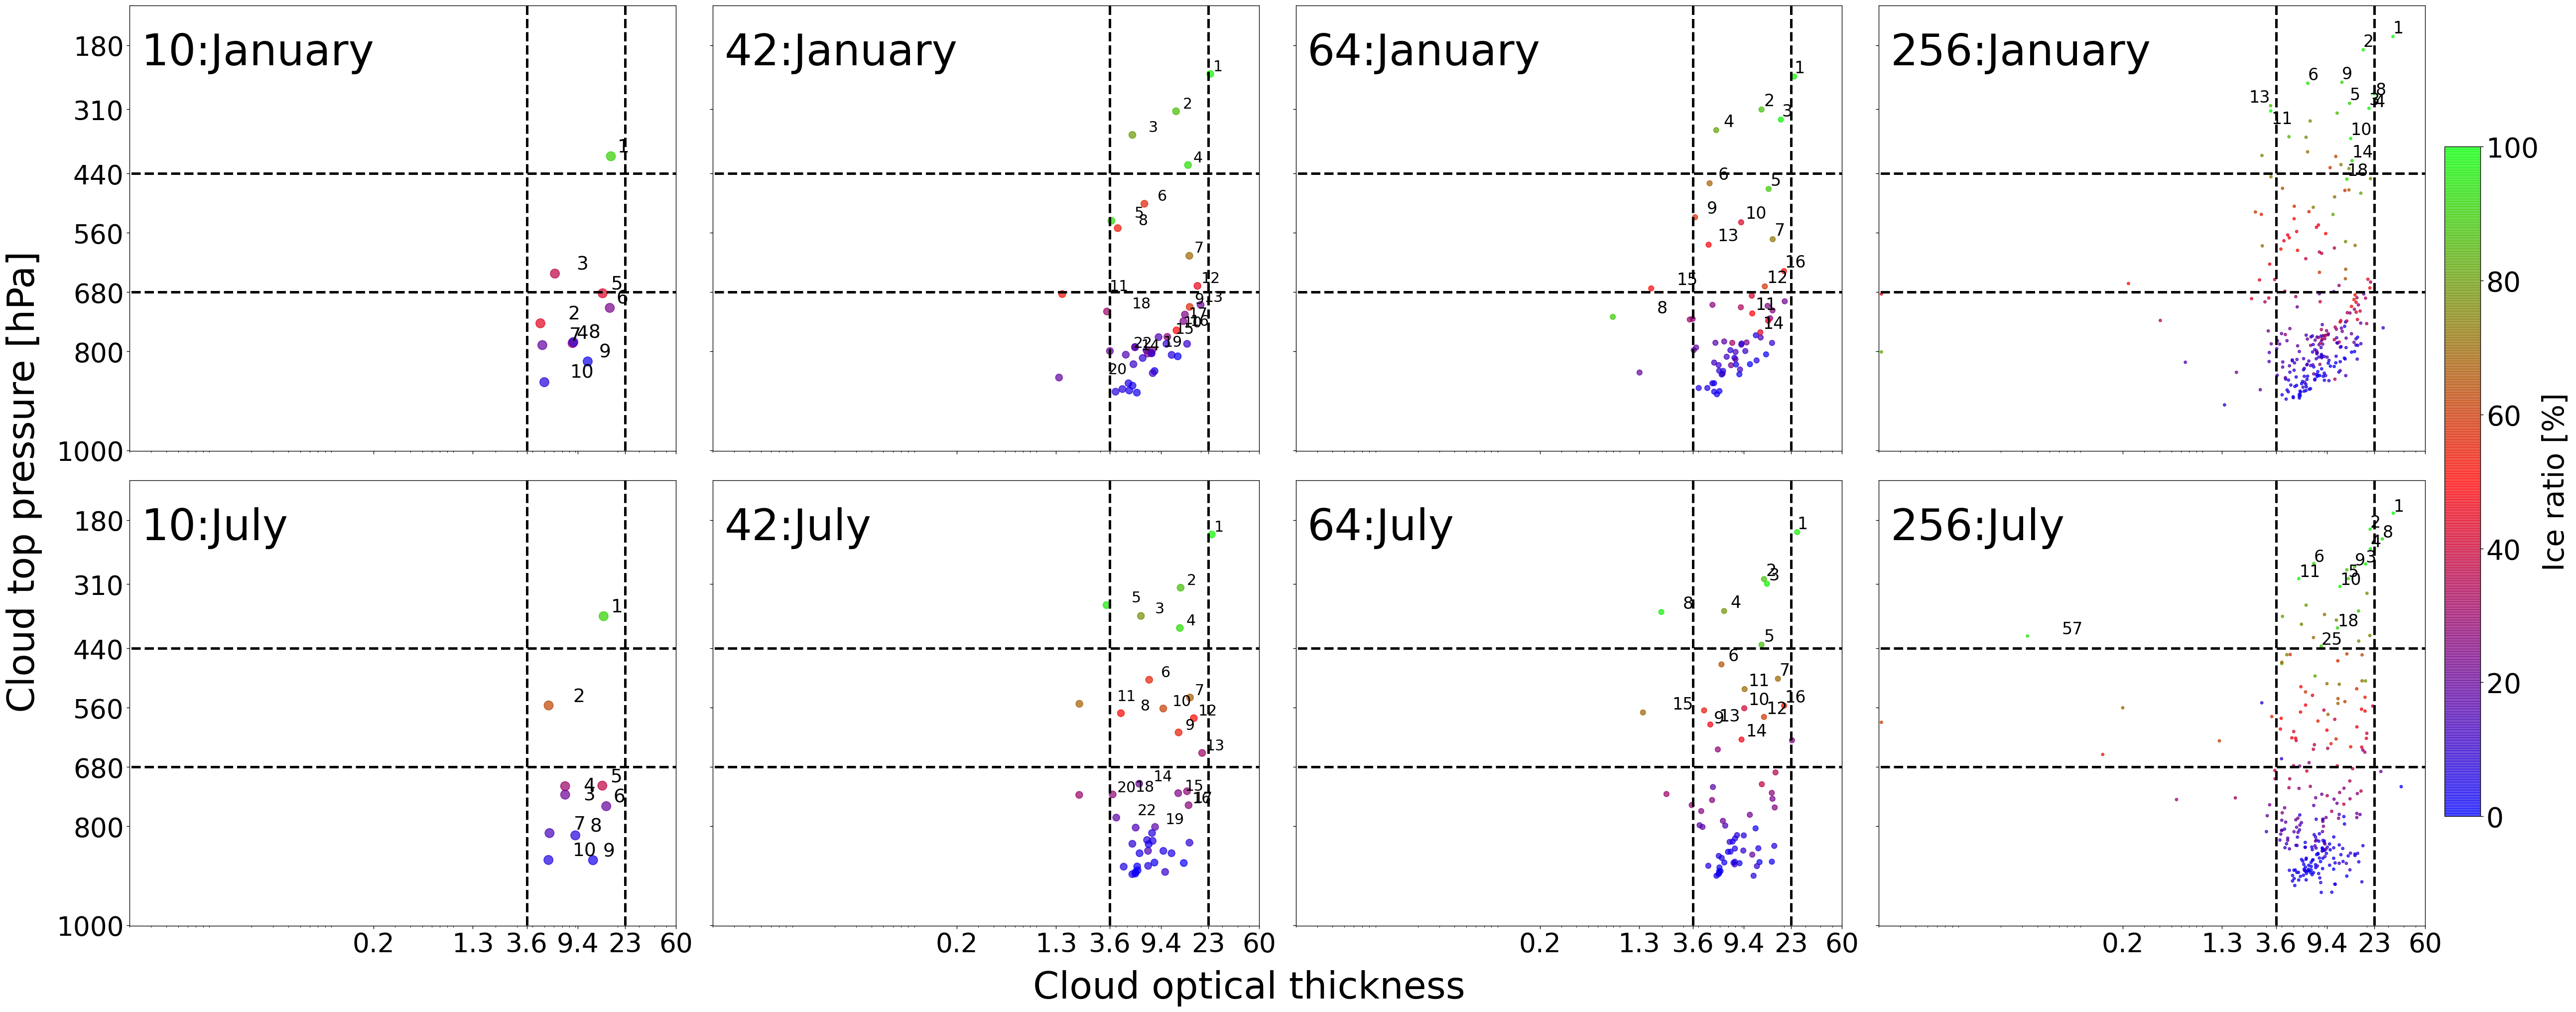

In [10]:
#fig = plt.figure(figsize=figsize)
#gs0 = gridspec.GridSpec(nrow, ncol, figure=fig)
fig, axs = plt.subplots(nrow, ncol, figsize=figsize, constrained_layout=True,dpi=120) #sharex=True, sharey=True,
tex_x_pos = {}


for col_idx, (ncluster, limit_annotate, thres_annotate, ew, caps, arrow,ss, ftex) in enumerate(
                                zip([10,42,64,256], 
                                    [False, True, True, True],[1,0.5,0.75, 0.95],
                                    [0.3,0.15,0.05,0.01],
                                    [1, 1, 1, 0.5],
                                    [False, False, False, False],
                                    [120,70,40,10],
                                    [15*1.5, 10*1.8, 10*2, 8*2.5]
                                    )):
    #for month, result_dicts in all_results.items():
    for row_idx, month in  enumerate(['jan', 'july']) :
        
        # axis
        ax = axs[row_idx, col_idx]
        #print(row_idx*nstep,(row_idx+1)*nstep, col_idx*nstep+col_idx,(col_idx+1)*nstep+col_idx,(col_idx+1)*nstep+col_idx+1)
        #ax = fig.add_subplot(gs0[row_idx*nstep:(row_idx+1)*nstep, col_idx*nstep+col_idx:(col_idx+1)*nstep+col_idx])
        
        #####################################
        result_dicts = all_results[month]
        # get data
        results = result_dicts['avg']
        moments = result_dicts['moments']
        labels  = result_dicts['labels']
    
        # position
        tex_x_pos[ncluster] = np.array([ i for i in results[ncluster][:,0]  ])
        
        # unroll
        opts =  results[ncluster][:,0] 
        eopts = moments[ncluster][:,0]
        
        zero_idx = np.where(opts == 0)
        if len(zero_idx) > 0:
            opts[zero_idx] += hxmin+0.0001
            
    
        sc = ax.scatter( opts, results[ncluster][:,1],s=ss,c=labels[ncluster][:,2]*100,
                        cmap=cmap, alpha=alpha,vmin=0, vmax=100 )
    
        # limit annotate data
        # limit annotate data
        if limit_annotate:
            # + 1 for index to align with the range from (1,ncluster)
            selected_clusters = np.where( 
            labels[ncluster][:,2]*100 >= np.quantile(labels[ncluster][:,2]*100, thres_annotate))[0] + 1
        else:
            selected_clusters = np.arange(1,ncluster+1,1)
    
        # text annotation
        texts = []
        xas, yas = [], []
        for ic, ix, iy in zip(np.arange(1,ncluster+1,1),tex_x_pos[ncluster], results[ncluster][:,1]):
            if ic in selected_clusters:
                ric = relabels[ncluster][ic]
                #ax.text(ix, iy, f'{ric}', fontsize=10,)
                #print(ax.get_xticks() , ax.get_yticks())
                #print(ix, iy)
                #if ix == 0:
                #    pass
                #else:
                texts.append(ax.text(ix, iy, f'{ric}', fontsize=ftex))
                #texts.append(ax.text(ix,(iy+dy), f'{ric}', fontsize=ftex,transform=ax.transData))
                #texts.append(ax.text(ix,(iy+dy), f'{ric}', fontsize=ftex,transform=ax.transData))

        #else:
        if flag_adjust:
            adjust_text(texts,ha='center', va='bottom') # 
            
        # y axis
        ax.set_ylim(100,1001)
        ax.set_yticks([180, 310,440,560, 680, 800, 1000])
        if col_idx == 0:
            ax.set_yticklabels([180, 310,440,560, 680, 800, 1000])
        else:
            ax.set_yticklabels([])
        ax.invert_yaxis()
        
        # x axis
        ax.set_xscale('log')
        ax.set_xlim(hxmin,hxmax)
        ax.xaxis.set_major_formatter(mticker.NullFormatter())
        ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
        ax.set_xticks([ i for i in [0.2, 1.3, 3.6, 9.4, 23, hxmax]])
        if row_idx == 1:
            ax.set_xticklabels([ str(i) for i in [0.2, 1.3, 3.6, 9.4, 23, hxmax]],  
                            )
        else:
            ax.set_xticklabels([])

        # v.2
        ax.hlines( 440, 0, hxmax, color='black', linestyle='--', linewidth=hlw)
        ax.hlines( 680, 0, hxmax, color='black', linestyle='--', linewidth=hlw)
        # vline
        ax.vlines(23, 100, 1000, color='black', linestyle='--',  linewidth=vlw)
        ax.vlines(3.6, 100, 1000, color='black', linestyle='--', linewidth=vlw )
    
        # size
        ax.tick_params(axis='both', labelsize=ftp)
        # subtitle to each 
        str_month = "January" if month == 'jan' else "July"
        ax.text(pos_sx, pos_sy,f"{ncluster}:{str_month}", fontsize=font_scale )


# colorbar
#fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.0, 0.15, 0.015, 0.7])
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.ax.set_ylabel('Ice ratio [%]', fontsize=fyl)
cbar.ax.tick_params(labelsize=tick_font_size)

fig.text(0.5, -0.04, 'Cloud optical thickness', fontsize=fts, ha='center')
fig.text(-0.02, 0.5, 'Cloud top pressure [hPa]', fontsize=fts, va='center', rotation='vertical')

#plt.show()
if flag_save:
        if PDF:
            #pdf = PdfPages(os.path.join(savefigdir, f'COT-CPT-RFO_{month}-{ncluster}.pdf') )
            pdf = PdfPages(os.path.join(savefigdir, f'COT-CPT-Ice_jan-july_MDPI.pdf') )
            plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
            pdf.close()
            pdf = None
        else:
            plt.savefig(os.path.join(savefigdir, f'COT-CPT-Ice_{month}-{ncluster}.png'))
else:
    plt.show()
    plt.close()